In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the heart disease dataset
df = pd.read_csv(r'C:\Users\ASAD\Downloads\heart_statlog_cleveland_hungary_final.csv')
df = df.dropna()
print(df.head())


   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  


               age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     1190.000000      1190.000000   
mean              0.213445     0.698319      139.732773         0.387395   
std               0.409912     0.870359       25.517636     

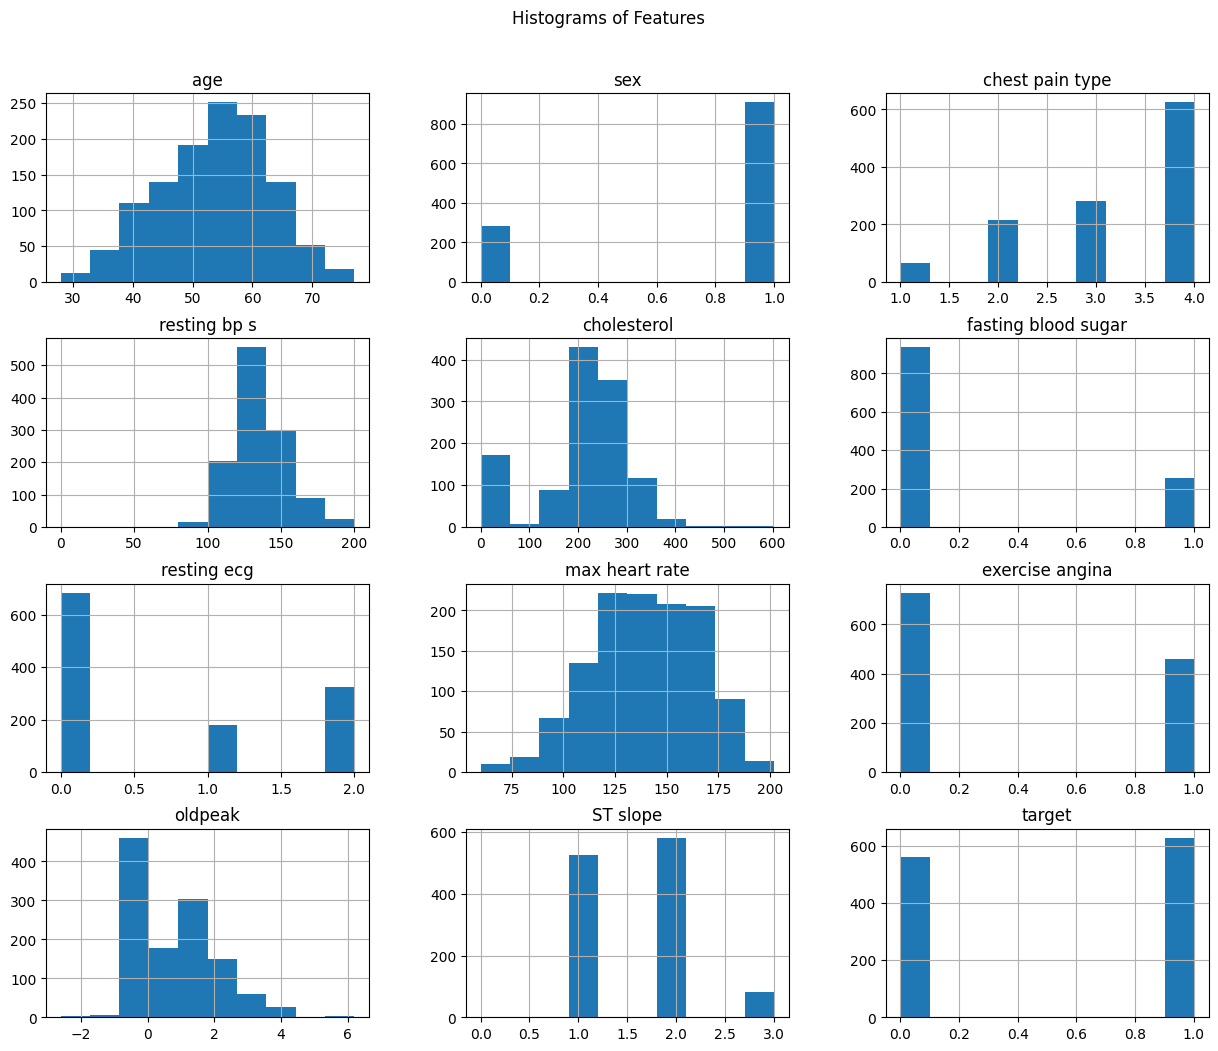

In [3]:
# Display summary statistics
summary_stats = df.describe()
print(summary_stats)

# Plot histograms for each feature
df.hist(figsize=(15, 12))
plt.suptitle('Histograms of Features', y=0.95)
plt.show()


In [4]:
# Separate features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']


# Split the data into training and testing sets using the required sample size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Distribution free approach of fisher scoring
import numpy as np
import pandas as pd
from sklearn.utils import resample
from scipy.stats import norm

# Fisher Scoring Algorithm with Bootstrapping
def fisher_scoring_bootstrap(X, y, max_iter=100, num_bootstrap=50, bootstrap_size=None):
    # Initialize a DataFrame to store bootstrap results
    bootstrap_results = pd.DataFrame()

    for _ in range(num_bootstrap):
        # Generate a bootstrap sample
        if bootstrap_size is None:
            bootstrap_X, bootstrap_y = resample(X, y, replace=True)
        else:
            bootstrap_X, bootstrap_y = resample(X, y, replace=True, n_samples=bootstrap_size)

        # Initialize weights for this bootstrap sample
        beta = np.zeros(bootstrap_X.shape[1] + 1)

        for _ in range(max_iter):
            # Add bias term to features
            X_bias = np.c_[np.ones(bootstrap_X.shape[0]), bootstrap_X]

            # Calculate predicted probabilities
            p = 1 / (1 + np.exp(-X_bias.dot(beta)))

            # Calculate weights
            W = np.diag(p * (1 - p))

            # Calculate score vector
            score = X_bias.T.dot(bootstrap_y - p)

            # Calculate Fisher Information Matrix
            fisher_info = X_bias.T.dot(W).dot(X_bias)

            # Update weights using Fisher Scoring update
            beta += np.linalg.inv(fisher_info).dot(score)

        # Calculate MLE estimate and maximum log-likelihood value for this bootstrap sample
        lambda_val = np.exp(np.dot(X_bias, beta))
        mle_estimate = np.mean(lambda_val)
        max_log_likelihood = np.sum(bootstrap_y * np.log(lambda_val) - lambda_val)

        # Store the results in the DataFrame
        bootstrap_results = pd.concat([bootstrap_results, pd.DataFrame({
            'MLE_Estimate': [mle_estimate],
            'Max_Log_Likelihood': [max_log_likelihood],
            'lambda_val': [lambda_val]
        })], ignore_index=True)

    # Calculate the mean and confidence intervals from the bootstrap results
    mle_estimate_mean = bootstrap_results['MLE_Estimate'].mean()
    mle_estimate_ci_lower = bootstrap_results['MLE_Estimate'].quantile(0.025)
    mle_estimate_ci_upper = bootstrap_results['MLE_Estimate'].quantile(0.975)

    max_log_likelihood_mean = bootstrap_results['Max_Log_Likelihood'].mean()
    max_log_likelihood_ci_lower = bootstrap_results['Max_Log_Likelihood'].quantile(0.025)
    max_log_likelihood_ci_upper = bootstrap_results['Max_Log_Likelihood'].quantile(0.975)

    final_results = pd.DataFrame({
        'MLE_Estimate_Mean': [mle_estimate_mean],
        'MLE_Estimate_CI_Lower': [mle_estimate_ci_lower],
        'MLE_Estimate_CI_Upper': [mle_estimate_ci_upper],
        'Max_Log_Likelihood_Mean': [max_log_likelihood_mean],
        'Max_Log_Likelihood_CI_Lower': [max_log_likelihood_ci_lower],
        'Max_Log_Likelihood_CI_Upper': [max_log_likelihood_ci_upper]
    }, index=[0])

    return beta, final_results

# Example usage with bootstrapping
weights,final_results = fisher_scoring_bootstrap(X_train_scaled, y_train)
print("Bootstrap Results:")
print(final_results)

# Extract MLE estimate and confidence intervals
mle_estimate_mean = final_results['MLE_Estimate_Mean'].values[0]
mle_estimate_ci_lower = final_results['MLE_Estimate_CI_Lower'].values[0]
mle_estimate_ci_upper = final_results['MLE_Estimate_CI_Upper'].values[0]

# Calculate standard error of the MLE estimate
se_mle_estimate = (mle_estimate_ci_upper - mle_estimate_ci_lower) / (2 * norm.ppf(0.975))

# Set the desired confidence level
confidence_level = 0.95

# Calculate the Z-score for the desired confidence level
z_score = norm.ppf((1 + confidence_level) / 2)

# Calculate the margin of error
margin_of_error = z_score * se_mle_estimate

# Calculate the confidence interval
confidence_interval_lower = mle_estimate_mean - margin_of_error
confidence_interval_upper = mle_estimate_mean + margin_of_error

# Print the results
print(f"MLE Estimate Mean: {mle_estimate_mean}")
print(f"MLE Estimate Confidence Interval: ({confidence_interval_lower}, {confidence_interval_upper})")



Bootstrap Results:
   MLE_Estimate_Mean  MLE_Estimate_CI_Lower  MLE_Estimate_CI_Upper  \
0          10.637029               6.601239              17.290108   

   Max_Log_Likelihood_Mean  Max_Log_Likelihood_CI_Lower  \
0             -9252.843536                  -15423.6583   

   Max_Log_Likelihood_CI_Upper  
0                 -5554.986851  
MLE Estimate Mean: 10.637029156195396
MLE Estimate Confidence Interval: (5.292594586364399, 15.981463726026394)

Feature Coefficients:
                Feature  Coefficient
2       chest pain type     0.731689
1                   sex     0.707752
10             ST slope     0.705856
8       exercise angina     0.512817
5   fasting blood sugar     0.390848
0                   age     0.300351
4           cholesterol    -0.286359
9               oldpeak     0.283653
7        max heart rate    -0.150964
3          resting bp s     0.134548
6           resting ecg     0.002072


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Apply Fisher Scoring Bootstrap to the test set
weights_test, final_results_test = fisher_scoring_bootstrap(X_test_scaled, y_test, num_bootstrap=1000, bootstrap_size=500)
print("Bootstrap Results on Test Set:")
print(final_results_test)


Bootstrap Results on Test Set:
   MLE_Estimate_Mean  MLE_Estimate_CI_Lower  MLE_Estimate_CI_Upper  \
0          20.994447               8.272753               52.05914   

   Max_Log_Likelihood_Mean  Max_Log_Likelihood_CI_Lower  \
0             -9885.933204                 -25336.58403   

   Max_Log_Likelihood_CI_Upper  
0                  -3654.25719  


In [22]:

# Extract MLE estimate and confidence intervals for the test set
mle_estimate_mean_test = final_results_test['MLE_Estimate_Mean'].values[0]
mle_estimate_ci_lower_test = final_results_test['MLE_Estimate_CI_Lower'].values[0]
mle_estimate_ci_upper_test = final_results_test['MLE_Estimate_CI_Upper'].values[0]

# Calculate standard error of the MLE estimate for the test set
se_mle_estimate_test = (mle_estimate_ci_upper_test - mle_estimate_ci_lower_test) / (2 * norm.ppf(0.975))

# Set the desired confidence level for the test set
confidence_level_test = 0.95

# Calculate the Z-score for the desired confidence level for the test set
z_score_test = norm.ppf((1 + confidence_level_test) / 2)

# Calculate the margin of error for the test set
margin_of_error_test = z_score_test * se_mle_estimate_test

# Calculate the confidence interval for the test set
confidence_interval_lower_test = mle_estimate_mean_test - margin_of_error_test
confidence_interval_upper_test = mle_estimate_mean_test + margin_of_error_test

# Print the results for the test set
print(f"MLE Estimate Mean on Test Set: {mle_estimate_mean_test}")
print(f"MLE Estimate Confidence Interval on Test Set: ({confidence_interval_lower_test}, {confidence_interval_upper_test})")

# Now calculate evaluation metrics on the test set
# weights_test, mle_info_test = fisher_scoring(X_test_scaled, y_test)

# Add bias term to test features
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# Calculate predicted probabilities
probabilities_test = 1 / (1 + np.exp(-X_test_bias.dot(weights_test)))

# Threshold probabilities to get binary predictions
predictions_test = (probabilities_test >= 0.5).astype(int)


# Calculate evaluation metrics for the test set
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_test = f1_score(y_test, predictions_test)
roc_auc_test = roc_auc_score(y_test, probabilities_test)

# Print metrics for the test set
print(f'Accuracy on Test Set: {accuracy_test:.2f}')
print(f'Precision on Test Set: {precision_test:.2f}')
print(f'Recall on Test Set: {recall_test:.2f}')
print(f'F1 Score on Test Set: {f1_test:.2f}')
print(f'ROC AUC on Test Set: {roc_auc_test:.2f}')

# Create a DataFrame with original values and predicted binary values
predictions_df = pd.DataFrame({
    'Original_Value': y_test.values,  # Assuming y_test is a pandas Series or DataFrame
    'Predicted_Binary': predictions_test,
    'Predicted_Probability': probabilities_test
})

# Print the DataFrame
print("\nOriginal Values and Predicted Binary Values:")
print(predictions_df)

MLE Estimate Mean on Test Set: 20.99444663160773
MLE Estimate Confidence Interval on Test Set: (-0.8987466480935069, 42.887639911308966)
Accuracy on Test Set: 0.83
Precision on Test Set: 0.86
Recall on Test Set: 0.82
F1 Score on Test Set: 0.84
ROC AUC on Test Set: 0.92

Original Values and Predicted Binary Values:
     Original_Value  Predicted_Binary  Predicted_Probability
0                 1                 1               0.939277
1                 1                 1               0.631055
2                 0                 0               0.004571
3                 1                 1               0.976048
4                 1                 0               0.457283
..              ...               ...                    ...
233               1                 1               0.952695
234               0                 0               0.141545
235               0                 0               0.057798
236               1                 1               0.951113
237          

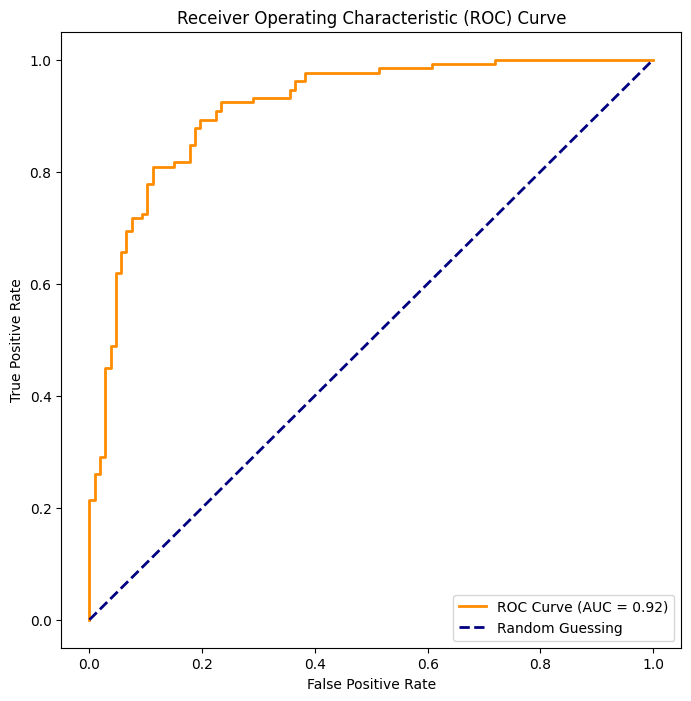

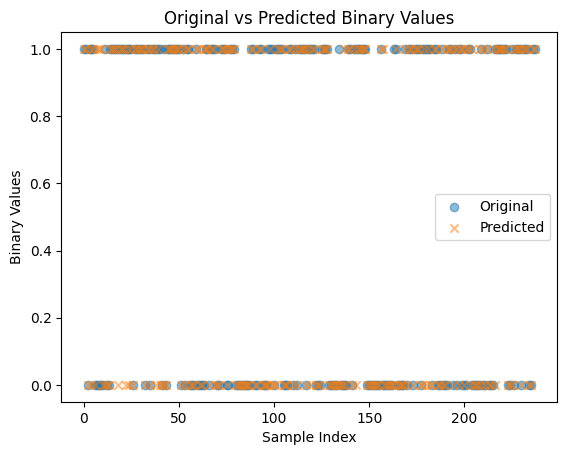

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Scatter plot for Original vs Predicted
plt.scatter(predictions_df.index, predictions_df['Original_Value'], label='Original', alpha=0.5)
plt.scatter(predictions_df.index, predictions_df['Predicted_Binary'], label='Predicted', marker='x', alpha=0.5)

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Binary Values')
plt.title('Original vs Predicted Binary Values')
plt.legend()

# Show the plot
plt.show()

